In [ ]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack,csr_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Assignment 9: GBDT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/Copy of preprocessed_data.csv')

##calculate sentiment scores for the essay feature

In [ ]:
sid = SentimentIntensityAnalyzer()
sents = data['essay'].values
pol_score_vec = np.vectorize(sid.polarity_scores)
senti_scores = pol_score_vec(sents)

pos =[]
neg =[]
neu = []
comp = []
for sc in senti_scores:
    pos.append(sc['pos'])
    neg.append(sc['neg'])
    neu.append(sc['neu'])
    comp.append(sc['compound'])

data["neg"] = neg
data["pos"] = pos
data["neu"] = neu        
data["comp"] = comp

##<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

##<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

###tfidf vectorization of text data

In [ ]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,4),max_features=5000)
x_train_essay_tfidf = tf_idf_vec.fit_transform(x_train['essay'].values)
x_test_essay_tfidf = tf_idf_vec.transform(x_test['essay'].values)

###tfidf w2v vectorization of text data

In [ ]:
tf_idf = TfidfVectorizer()
tf_idf.fit(x_train['essay'])
tfidf_dict = dict(zip(tf_idf.get_feature_names_out(),list(tf_idf.idf_)))
tfidf_ftrs=set(tf_idf.get_feature_names_out())

with open('/content/drive/MyDrive/Colab Notebooks/assignment files/Copy of glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

def tfidf_w2v(x_train,model,glove_words,tf_idf_ftrs,tfidf_dict):
    tfidf_w2v =[]
    for essay in x_train:
        vec = np.zeros(300)
        tfidf_sum = 0
        for word in essay.split():
            if (word in glove_words) and (word in tf_idf_ftrs):
                vec += model[word]*tfidf_dict[word]
                tfidf_sum +=tfidf_dict[word]
        if tfidf_sum != 0:
            vec /=tfidf_sum
        tfidf_w2v.append(vec)
    return np.array(tfidf_w2v)

x_train_tfidf_w2v = tfidf_w2v(x_train['essay'],model,glove_words,tfidf_ftrs,tfidf_dict)
print("x_train_tfidfw2v",x_train_tfidf_w2v.shape)

x_test_tfidf_w2v = tfidf_w2v(x_test['essay'],model,glove_words,tfidf_ftrs,tfidf_dict)
print('x_test_tfidf_w2v',x_test_tfidf_w2v.shape)

x_train_tfidfw2v (73196, 300)
x_test_tfidf_w2v (36052, 300)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
def cat_encoder(f_tr,f_te,y_tr,y_te):
    count_dict ={}
    for val in f_tr:
        count = 0
        if val  not in count_dict.keys():
            for i in f_tr:
                if val == i:
                    count+= 1
            count_dict[val] = count
    count0_dict={}
    for val in f_tr:
        count0 = 0
        if val not in count0_dict.keys():
            for idx,val1 in enumerate(f_tr):
                if (val == val1) and ( y_tr[idx] == 0):
                    count0 += 1
            count0_dict[val] = count0
    
    cat_enc_tr =[]
    for val in f_tr:
        lst = []
        prob0 = count0_dict[val]/count_dict[val]
        lst.append(prob0)
        lst.append(1-prob0)
        cat_enc_tr.append(lst)

    cat_enc_te = []
    for val in f_te:
        lst =[]
        if val in count_dict.keys():
            prob0 = count0_dict[val]/count_dict[val]
            lst.append(prob0)
            lst.append(1-prob0)
            cat_enc_te.append(lst)
        else:
            cat_enc_te.append([0.5,0.5])


    print("After vectorizations")
    print(np.array(cat_enc_tr).shape, y_train.shape)
    print(np.array(cat_enc_te).shape, y_test.shape)
    return np.array(cat_enc_tr),np.array(cat_enc_te)
    
    


###Encoding school_state

In [ ]:
x_train_state_ohe, x_test_state_ohe = cat_encoder(x_train['school_state'],x_test['school_state'],y_train,y_test) 

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###Encoding teacher_prefix

In [ ]:
x_train_teacher_prefix_ohe, x_test_teacher_prefix_ohe = cat_encoder(x_train['teacher_prefix'],x_test['teacher_prefix'],y_train,y_test)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###Encoding project_grade_category

In [ ]:
x_train_pgc_ohe, x_test_pgc_ohe = cat_encoder(x_train['project_grade_category'],x_test['project_grade_category'],y_train,y_test)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###Encoding clean_categories

In [ ]:
x_train_clean_cat_ohe, x_test_clean_cat_ohe = cat_encoder(x_train['clean_categories'],x_test['clean_categories'],y_train,y_test)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###Encoding clean_subcategories

In [ ]:
x_train_clean_subcat_ohe, x_test_clean_subcat_ohe = cat_encoder(x_train['clean_subcategories'],x_test['clean_subcategories'],y_train,y_test)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


###Encdoing numerical features

In [ ]:
def num_encoder(f_tr,f_te,y_tr,y_te):
    normalizer = Normalizer()
    normalizer.fit(f_tr.values.reshape(-1, 1))

    f_tr_norm = normalizer.transform(f_tr.values.reshape(-1,1))
    f_te_norm = normalizer.transform(f_te.values.reshape(-1,1))

    print("After vectorizations")
    print(f_tr_norm.shape, y_train.shape)
    print(f_te_norm.shape, y_test.shape)
    print("="*100)
    return f_tr_norm,f_te_norm

###Encoding price

In [ ]:
x_train_price_norm,x_test_price_norm = num_encoder(x_train['price'],x_test['price'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###Encoding Teacher number of previously posted projects

In [ ]:
x_train_tppp_norm,x_test_tppp_norm = num_encoder(x_train['teacher_number_of_previously_posted_projects'],x_test['teacher_number_of_previously_posted_projects'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###Encoding neg

In [ ]:
x_train_neg_norm,x_test_neg_norm = num_encoder(x_train['neg'],x_test['neg'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### Encoding pos

In [ ]:
x_train_pos_norm,x_test_pos_norm = num_encoder(x_train['pos'],x_test['pos'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###Encoding neu

In [ ]:
x_train_neu_norm,x_test_neu_norm = num_encoder(x_train['neu'],x_test['neu'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


###Encoding comp

In [ ]:
x_train_comp_norm,x_test_comp_norm = num_encoder(x_train['comp'],x_test['comp'],y_train,y_test)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
def all_plots(x_tr_set_1):
    params ={'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':[5,10,20,40]}

    gbdt = GradientBoostingClassifier()
    grid_search = GridSearchCV(gbdt,params,cv=5,scoring='roc_auc',return_train_score = True,n_jobs = -1)
    grid_search.fit(x_tr_set1,y_train)

    train_auc = grid_search.cv_results_['mean_train_score']
    train_auc_stdd = grid_search.cv_results_['std_train_score']
    cv_auc = grid_search.cv_results_['mean_test_score']
    cv_auc_std = grid_search.cv_results_['std_test_score']

    print("Best score",grid_search.best_score_)
    print('Best Hyper parameters',grid_search.best_params_)

    #heat map
    sns.heatmap(train_auc.reshape(4,4),annot = True,yticklabels =[0.1,0.2,0.3,0.4],xticklabels=[5,10,20,40],cmap="Blues")
    plt.ylabel("learning_rate")
    plt.xlabel("n_estimators")
    plt.title("Train_AUC plot")
    plt.show()
    print("\n")
    sns.heatmap(cv_auc.reshape(4,4),annot = True,yticklabels =[0.1,0.2,0.3,0.4],xticklabels=[5,10,20,40],cmap="Blues")
    plt.title("CV_AUC plot")
    plt.ylabel("learning_rate")
    plt.xlabel("n_estimators")
    plt.show()
    #ROC curve
    dt_set1 =gbdt.set_params(learning_rate=grid_search.best_params_['learning_rate'],n_estimators=grid_search.best_params_['n_estimators'])
    dt_set1.fit(x_tr_set1,y_train)

    y_train_pred = dt_set1.predict_proba(x_tr_set1)
    y_test_pred = dt_set1.predict_proba(x_te_set1)

    train_fpr,train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred[:,1])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:,1])

    plt.plot(train_fpr, train_tpr,label="train_AUC="+str(auc(train_fpr,train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test_AUC="+str(auc(test_fpr,test_tpr)))

    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC curve")
    plt.grid()
    plt.show()
    # confusion matrix
    best_t_tr = find_best_threshold(tr_thresholds,train_fpr,train_tpr)
    conf_mat_tr = confusion_matrix(y_train,predict_with_best_t(y_train_pred[:,1],best_t_tr))

    sns.heatmap(conf_mat_tr,annot=True,fmt = 'd',cmap='Blues',cbar=False)
    plt.title("Train Confusion Matix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.show()
    print()
    best_t_te = find_best_threshold(te_thresholds,test_fpr,test_tpr)
    conf_mat_te = confusion_matrix(y_test,predict_with_best_t(y_test_pred[:,1],best_t_te))

    sns.heatmap(conf_mat_te,annot=True,fmt = 'd',cmap='Blues',cbar=False)
    plt.title("Test Confusion Matix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.show()

##Set 1

In [ ]:

x_tr_set1 = hstack((x_train_essay_tfidf,x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_pgc_ohe,x_train_clean_cat_ohe,x_train_clean_subcat_ohe,x_train_price_norm,x_train_tppp_norm,x_train_neg_norm,x_train_pos_norm,x_train_neu_norm,x_train_comp_norm)).tocsr()
x_te_set1 = hstack((x_test_essay_tfidf, x_test_state_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe,x_test_clean_cat_ohe,x_test_clean_subcat_ohe, x_test_price_norm,x_test_tppp_norm,x_test_neg_norm,x_test_pos_norm,x_test_neu_norm,x_test_comp_norm)).tocsr()

print("Final Data matrix")
print(x_tr_set1.shape, y_train.shape)
print(x_te_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5016) (73196,)
(36052, 5016) (36052,)


Best score 0.6914457002571168
Best Hyper parameters {'learning_rate': 0.4, 'n_estimators': 40}


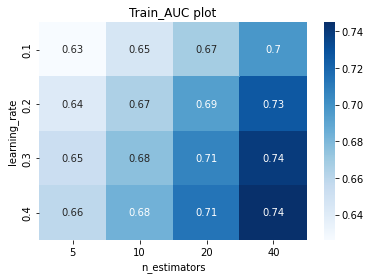

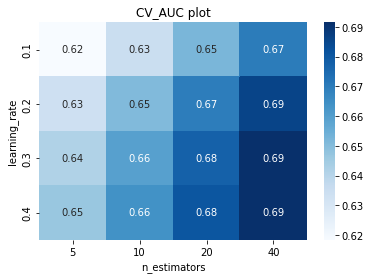

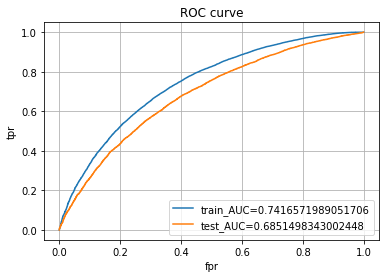

the maximum value of tpr*(1-fpr) 0.46085813923742547 for threshold 0.845


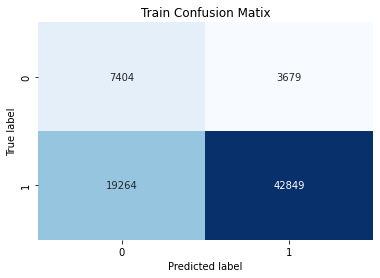


the maximum value of tpr*(1-fpr) 0.4071760995531288 for threshold 0.852


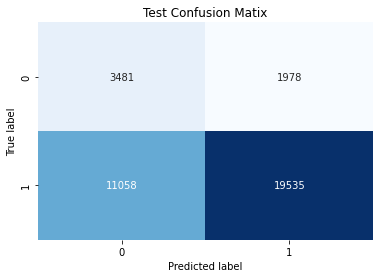

In [ ]:
all_plots(x_tr_set1)

##Set2

In [ ]:
x_tr_set2 = hstack((csr_matrix(x_train_tfidf_w2v),x_train_state_ohe,x_train_teacher_prefix_ohe,x_train_pgc_ohe,x_train_clean_cat_ohe,x_train_clean_subcat_ohe,x_train_price_norm,x_train_tppp_norm,x_train_neg_norm,x_train_pos_norm,x_train_neu_norm,x_train_comp_norm)).tocsr()
x_te_set2 = hstack((csr_matrix(x_test_tfidf_w2v), x_test_state_ohe, x_test_teacher_prefix_ohe, x_test_pgc_ohe,x_test_clean_cat_ohe,x_test_clean_subcat_ohe, x_test_price_norm,x_test_tppp_norm,x_test_neg_norm,x_test_pos_norm,x_test_neu_norm,x_test_comp_norm)).tocsr()

print("Final Data matrix")
print(x_tr_set2.shape, y_train.shape)
print(x_te_set2.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 316) (73196,)
(36052, 316) (36052,)


Best score 0.6913842949509539
Best Hyper parameters {'learning_rate': 0.4, 'n_estimators': 40}


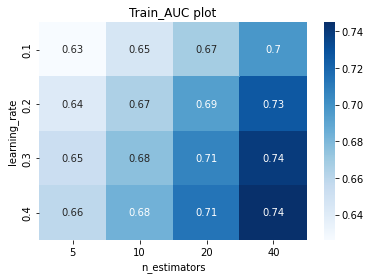

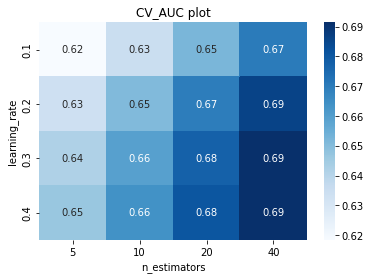

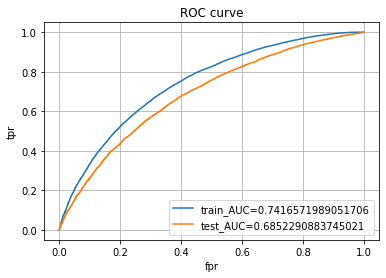

the maximum value of tpr*(1-fpr) 0.46085813923742547 for threshold 0.845


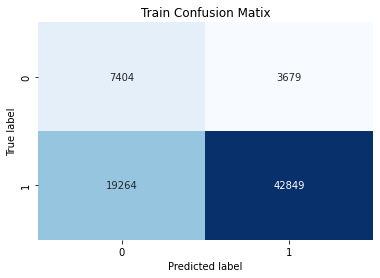


the maximum value of tpr*(1-fpr) 0.40721778638185196 for threshold 0.852


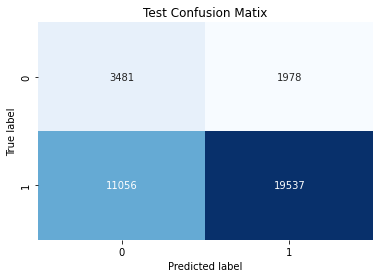

In [ ]:
all_plots(x_tr_set2)

#<h1>3. Summary</h1>



In [ ]:
from prettytable import PrettyTable, ALL

table = PrettyTable(hrules =ALL)
table.field_names= ["VECTORIZER","MODEL","learning_rate","n_estimators",'AUC']
table.add_row(["TFIDF","GBDT",0.4,40,0.69445])
table.add_row(["TFIDF W2V","GBDT",5,100,0.69437])

print(table)

+------------+-------+---------------+--------------+---------+
| VECTORIZER | MODEL | learning_rate | n_estimators |   AUC   |
+------------+-------+---------------+--------------+---------+
|   TFIDF    |  GBDT |      0.4      |      40      | 0.69445 |
+------------+-------+---------------+--------------+---------+
| TFIDF W2V  |  GBDT |       5       |     100      | 0.69437 |
+------------+-------+---------------+--------------+---------+
